## Initialize a Custom Dark-Punk Theme Matplotlib

In [103]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = "retina"

# ----------------------------
# Dark theme palette
# ----------------------------
DARK_FIG = "k"            # figure background
DARK_AX  = "#0f1626"      # axes background
FG       = "#e6e6e6"      # foreground text/ticks
GRID_C   = "#2a3448"      # grid lines
LEG_BG   = "#0b1220"      # legend background
LEG_EDGE = "#3a465f"      # legend edge

# ----------------------------
# Bold, journal-style defaults + dark theme
# ----------------------------
mpl.rcParams.update({
    # Fonts & math
    "font.family": "sans-serif",
    "mathtext.fontset": "cm",
    "font.size": 15,
    "axes.titlesize": 18,
    "axes.labelsize": 18,

    # Axes & spines
    "axes.linewidth": 2.6,
    "axes.labelpad": 8,
    "axes.facecolor": DARK_AX,
    "axes.edgecolor": FG,
    "axes.labelcolor": FG,

    # Ticks
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.size": 9,
    "ytick.major.size": 9,
    "xtick.minor.size": 5,
    "ytick.minor.size": 5,
    "xtick.major.width": 2.2,
    "ytick.major.width": 2.2,
    "xtick.minor.width": 1.8,
    "ytick.minor.width": 1.8,
    "xtick.major.pad": 6,
    "ytick.major.pad": 6,
    "xtick.color": FG,
    "ytick.color": FG,

    # Grid
    "axes.grid": False,
    "grid.color": GRID_C,

    # Text
    "text.color": FG,

    # Lines
    "lines.linewidth": 2.4,
    "lines.markersize": 6,

    # Legend (auto-dark)
    "legend.frameon": True,
    "legend.facecolor": LEG_BG,
    "legend.edgecolor": LEG_EDGE,
    "legend.framealpha": 0.95,
    "legend.fontsize": 15,
    "legend.borderaxespad": 1,

    # Figure / saving
    "figure.facecolor": DARK_FIG,
    "savefig.facecolor": DARK_FIG,
    "savefig.edgecolor": DARK_FIG,
    "figure.dpi": 150,
    "savefig.dpi": 350,
    "savefig.bbox": "tight",
})

# ----------------------------
# Other imports
# ----------------------------
import batman
import numpy as np

## Simulate a repeating exoplanet transit with `batman`

In [60]:
# let's start with defining transit parameters defult from baTman
params = batman.TransitParams()
params.t0 = 0.                       #time of inferior conjunction
params.per = 1.8                     #orbital period
params.rp = 0.9                      #planet radius (in units of stellar radii)
params.a = 9.                       #semi-major axis (in units of stellar radii)
params.inc = 87.                     #orbital inclination (in degrees)
params.ecc = 0.                      #eccentricity
params.w = 90.                       #longitude of periastron (in degrees)
params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic"       #limb darkening model

In [326]:
# helper functions

def find_largest_gap(time_array, return_indices=False):
    """For a given time array, find the largest gap between consecutive observations.

    Parameters
    ----------
    time_array : array-like
        An array of time observations

    Returns
    -------
    gap_start : float
        The time at the start of the largest gap
    gap_end : float
        The time at the end of the largest gap
    ��� or ���
    idx_start : int
        The index of the time at the start of the largest gap
    idx_end : int
        The index of the time at the end of the largest gap
    """

    check_sort = np.all(sorted(time_array)==time_array)

    if not check_sort:
        print ("Time array not sorted. Sorting now...")
        time_array = time_array[np.argsort(time_array)]


    delta_time = np.diff(time_array)

    if return_indices:
        return np.argmax(delta_time), np.argmax(delta_time)+1
    else:
        return time_array[np.argmax(delta_time)], time_array[np.argmax(delta_time)+1]


Text(0, 0.5, 'Norm. Flux')

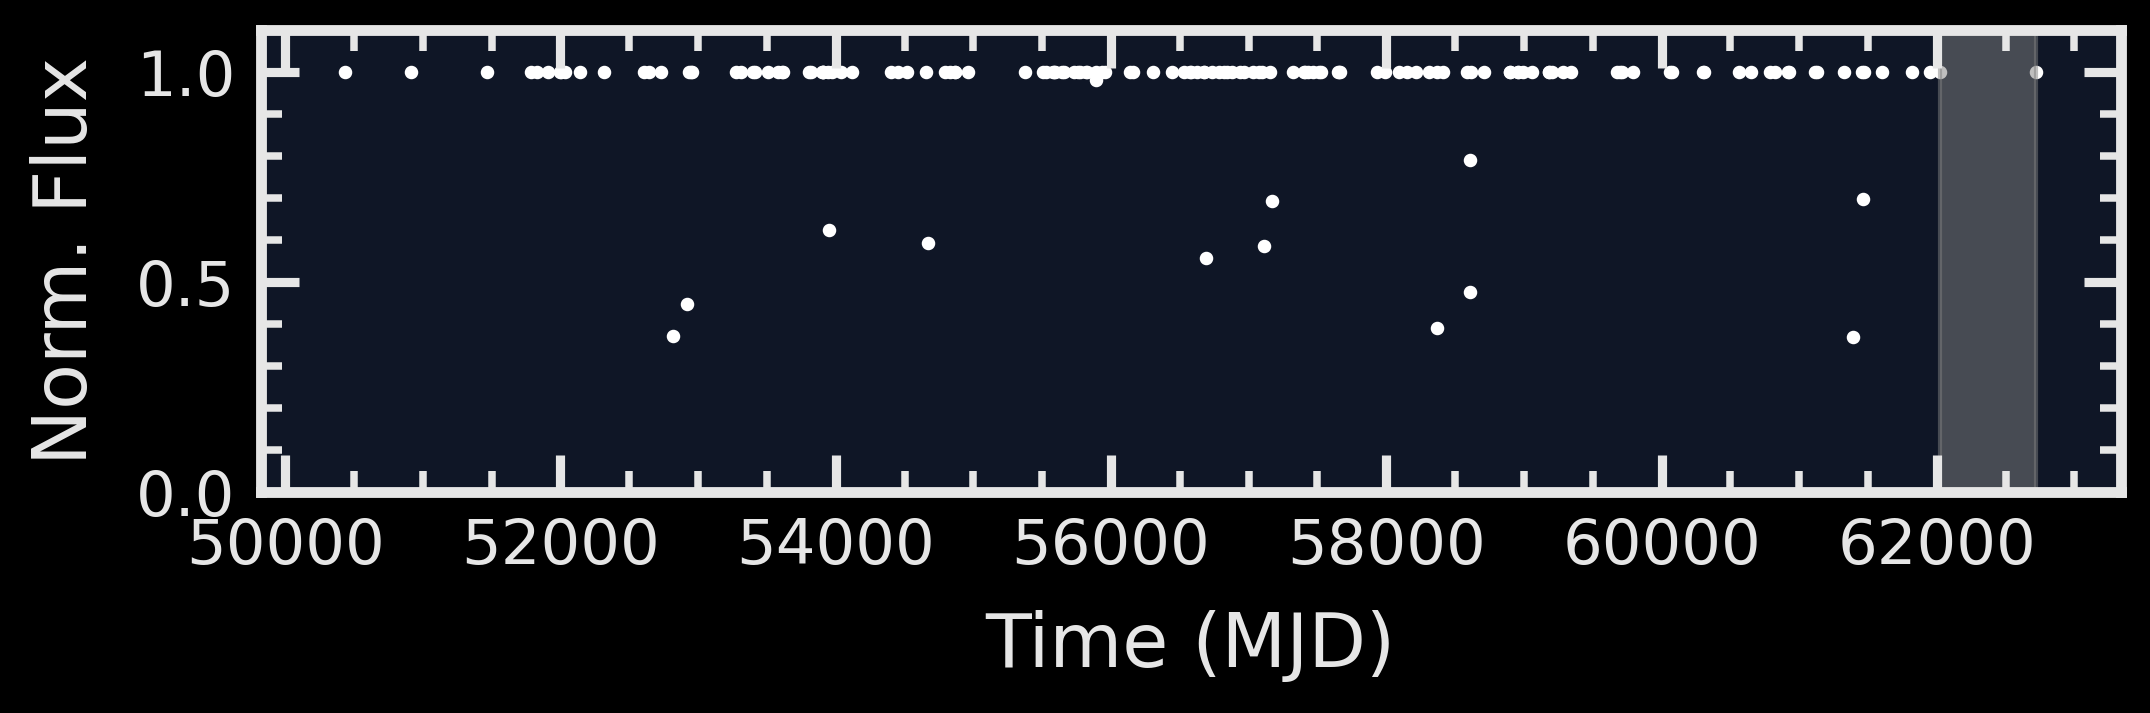

In [327]:
# let's assume we're dealing with MJD format time
mjd_min = 52000
mjd_max = 61000

Nobs = 150
seed_gen = np.random.default_rng(np.random.randint(1e3))
tobs = np.linspace(mjd_min, mjd_max, Nobs)
tobs += seed_gen.integers(0, 1e1, size=Nobs)
tobs += seed_gen.normal(1e1, 1e3, size=Nobs)
tobs = tobs[np.argsort(tobs)]

m = batman.TransitModel(params, tobs) 
flux = m.light_curve(params)

t_large_gap = find_largest_gap(tobs)

plt.figure(figsize=(8,2))
plt.scatter(tobs, flux, color='w', s=5)
plt.axvspan(t_large_gap[0], t_large_gap[1], color='gray', alpha=0.5)

plt.ylim(0, 1.1)
plt.xlabel("Time (MJD)")
plt.ylabel("Norm. Flux")

## Question: 

You can imagine the scenario where we have some $X_{obs}$ timeseires of some **periodic** signal. Let's make a few assumptions: 
1. It's the only repeating periodic signal
2. It *may* appear under the same transit parameters
3. **As the observer** we know the (i) period and (ii) duration of the transit

Next, we're given that the time interval $X_{obs}$ is not evenly sampled. Naturally, as we're analyzing the data we ask: 
```
Given a noisy and sparsely sampleed light curve, where else did we miss the transit?
```

In [708]:
def square_function(x, t0, C, A, width):
    """Generate a square function centered at t0 with amplitude A and width.

    Parameters
    ----------
    x : array-like
        The input x values
    t0 : float
        The center of the square function
    A : float
        The amplitude of the square function
    C : float
        The vertical offset of the square function
    width : float
        The width of the square function

    Returns
    -------
    y : array-like
        The output y values of the square function
    """
    y = np.zeros_like(x)
    y[(x >= (t0 - width/2)) & (x <= (t0 + width/2))] = A
    y += C
    return y

def repeat_square(X, params, period):
    """Naive andy repeat function for square function.
        params: [t0_start, C, A, width]
    """
    t0_start = params[0] # start of the phase
    duration = params[3]      # duration of the event

    # start with base function at the known t0_start
    base_func = square_function(X, *params)

    # find all the t0 phases to repeat the function at
    t0_all_z = []
    for i in range(1, int((max(X)-t0_start)/2)):
        t0_all_z.append(t0_start+i*period)

    for i in range(1, int((t0_start - min(X))/2)):
        t0_all_z.append(t0_start-i*period)

    t0_all_z = np.array(t0_all_z)

    for i in range(0, len(t0_all_z)):
        base_func += square_function(X, t0=t0_all_z[i], C=params[1], A=params[2], width=params[3])

    base_func /= len(t0_all_z) + 1
    
    return base_func

In [ ]:
rng = np.random.default_rng(42)

t0 = 59000.0          # start MJD
nyears = 4.0
tend = t0 + 365.25*nyears

# --- baseline ~2–3 day cadence with jitter + occasional longer gaps ---
t = [t0 + rng.uniform(0, 2)]
while t[-1] < tend:
    dt = rng.normal(2.5, 1.0)          # average ~2.5d cadence
    dt = np.clip(dt, 0.3, 15.0)        # allow some weird longer gaps
    t.append(t[-1] + dt)

t = np.array(t[:-1], dtype=float)

phase = (t - t0) % 365.25
t = t[phase < 210.0]                   # ~210d observing season, ~155d seasonal gap

for _ in range(10):
    gs = rng.uniform(t0, tend - 1)
    gl = rng.uniform(2, 12)            # 2–12 day gaps
    t = t[~((t >= gs) & (t <= gs + gl))]

for _ in range(3):
    gs = rng.uniform(t0, tend - 1)
    gl = rng.uniform(10, 35)           # 10–35 day gaps
    t = t[~((t >= gs) & (t <= gs + gl))]


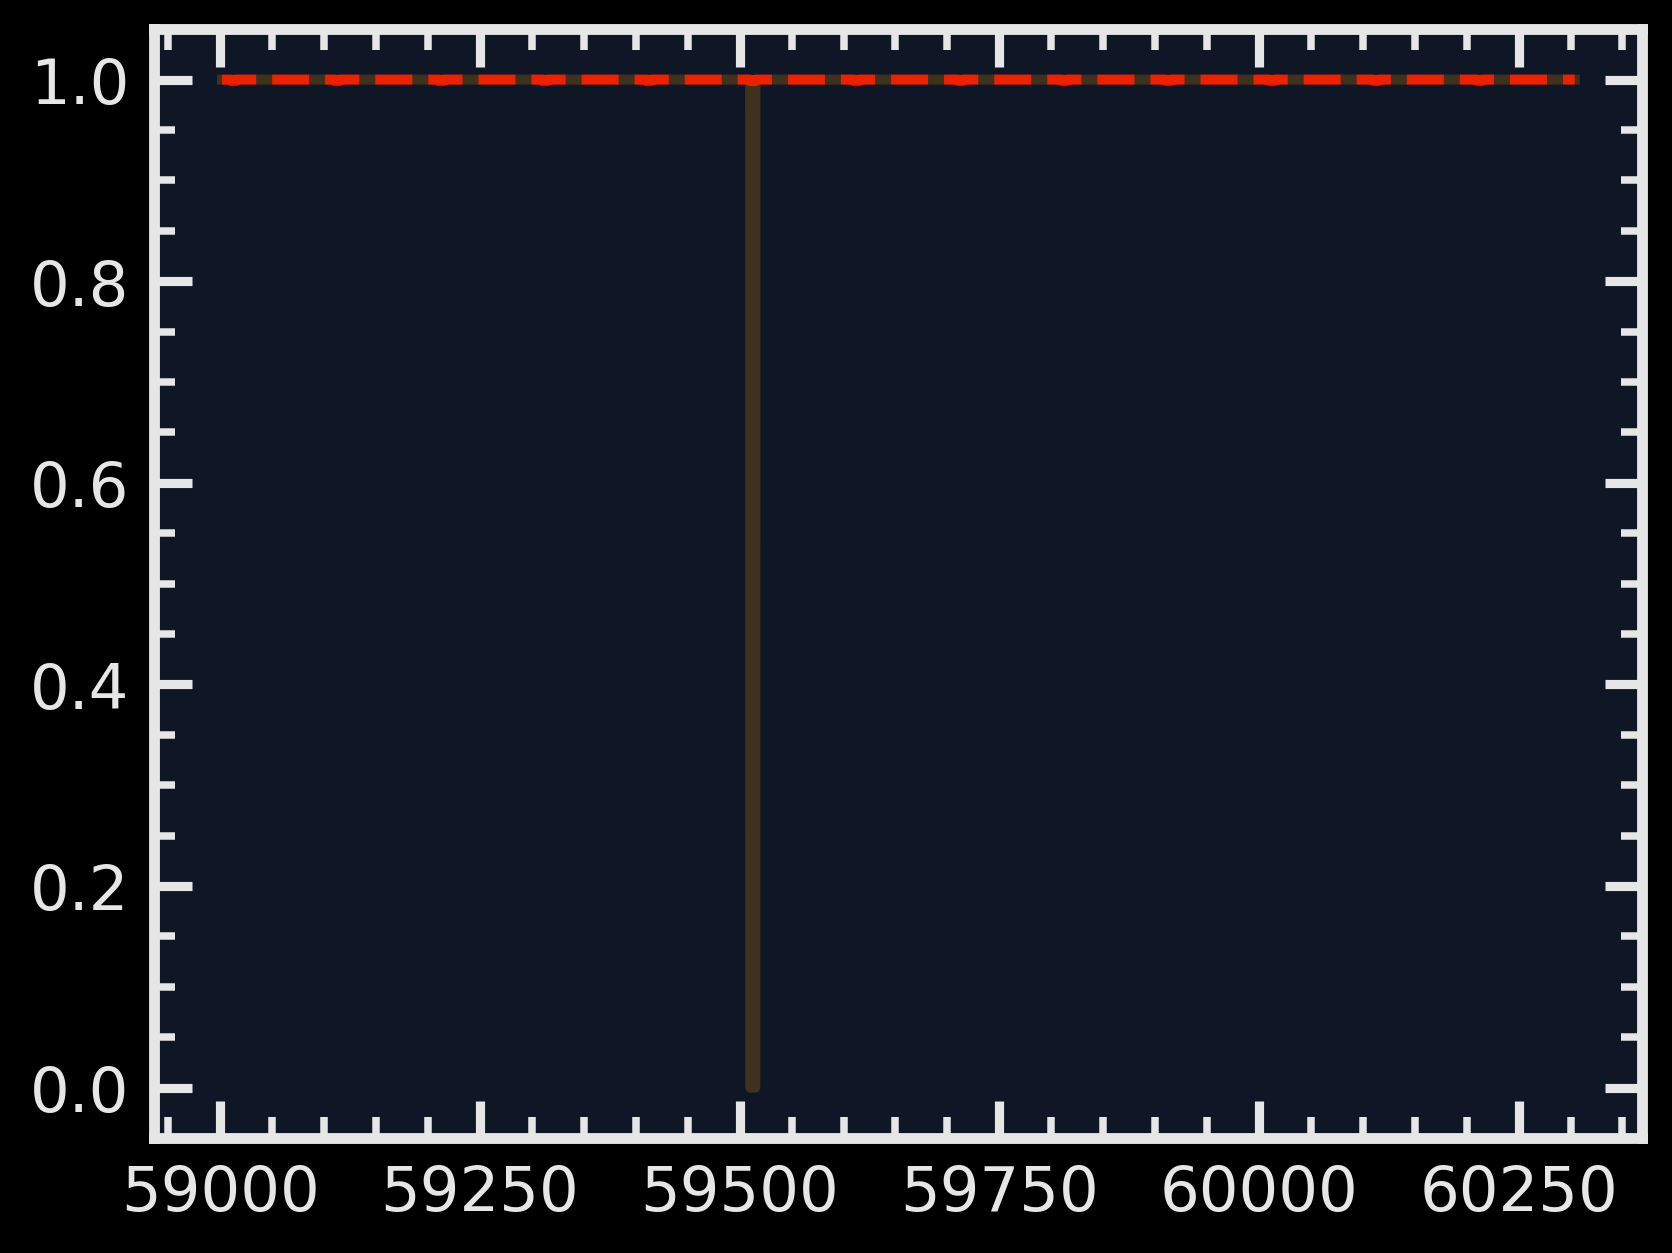

In [ ]:
t = np.sort(np.unique(t))              # final time array
x_cont = np.linspace(min(t), max(t), 10000)

t0_inj = 59512.593543996576
C_inj = 1
A_inj = -1
width_inj = 5

# t0_start, C, A, width
model_repeat = repeat_square(x_cont, params=[t0_inj, C_inj, A_inj, width_inj], period=100)

model = square_function(t, t0=t0_inj, A=A_inj, C=C_inj, width=width_inj)
model_cont = square_function(x_cont, t0=t0_inj, A=A_inj, C=C_inj, width=width_inj)

plt.plot(x_cont, model_repeat, color='red', alpha=0.9, ls='--')
plt.plot(x_cont, model_cont, color='orange', alpha=0.2)



In [683]:
len(model_repeat), len(x_cont)

(10000, 10000)

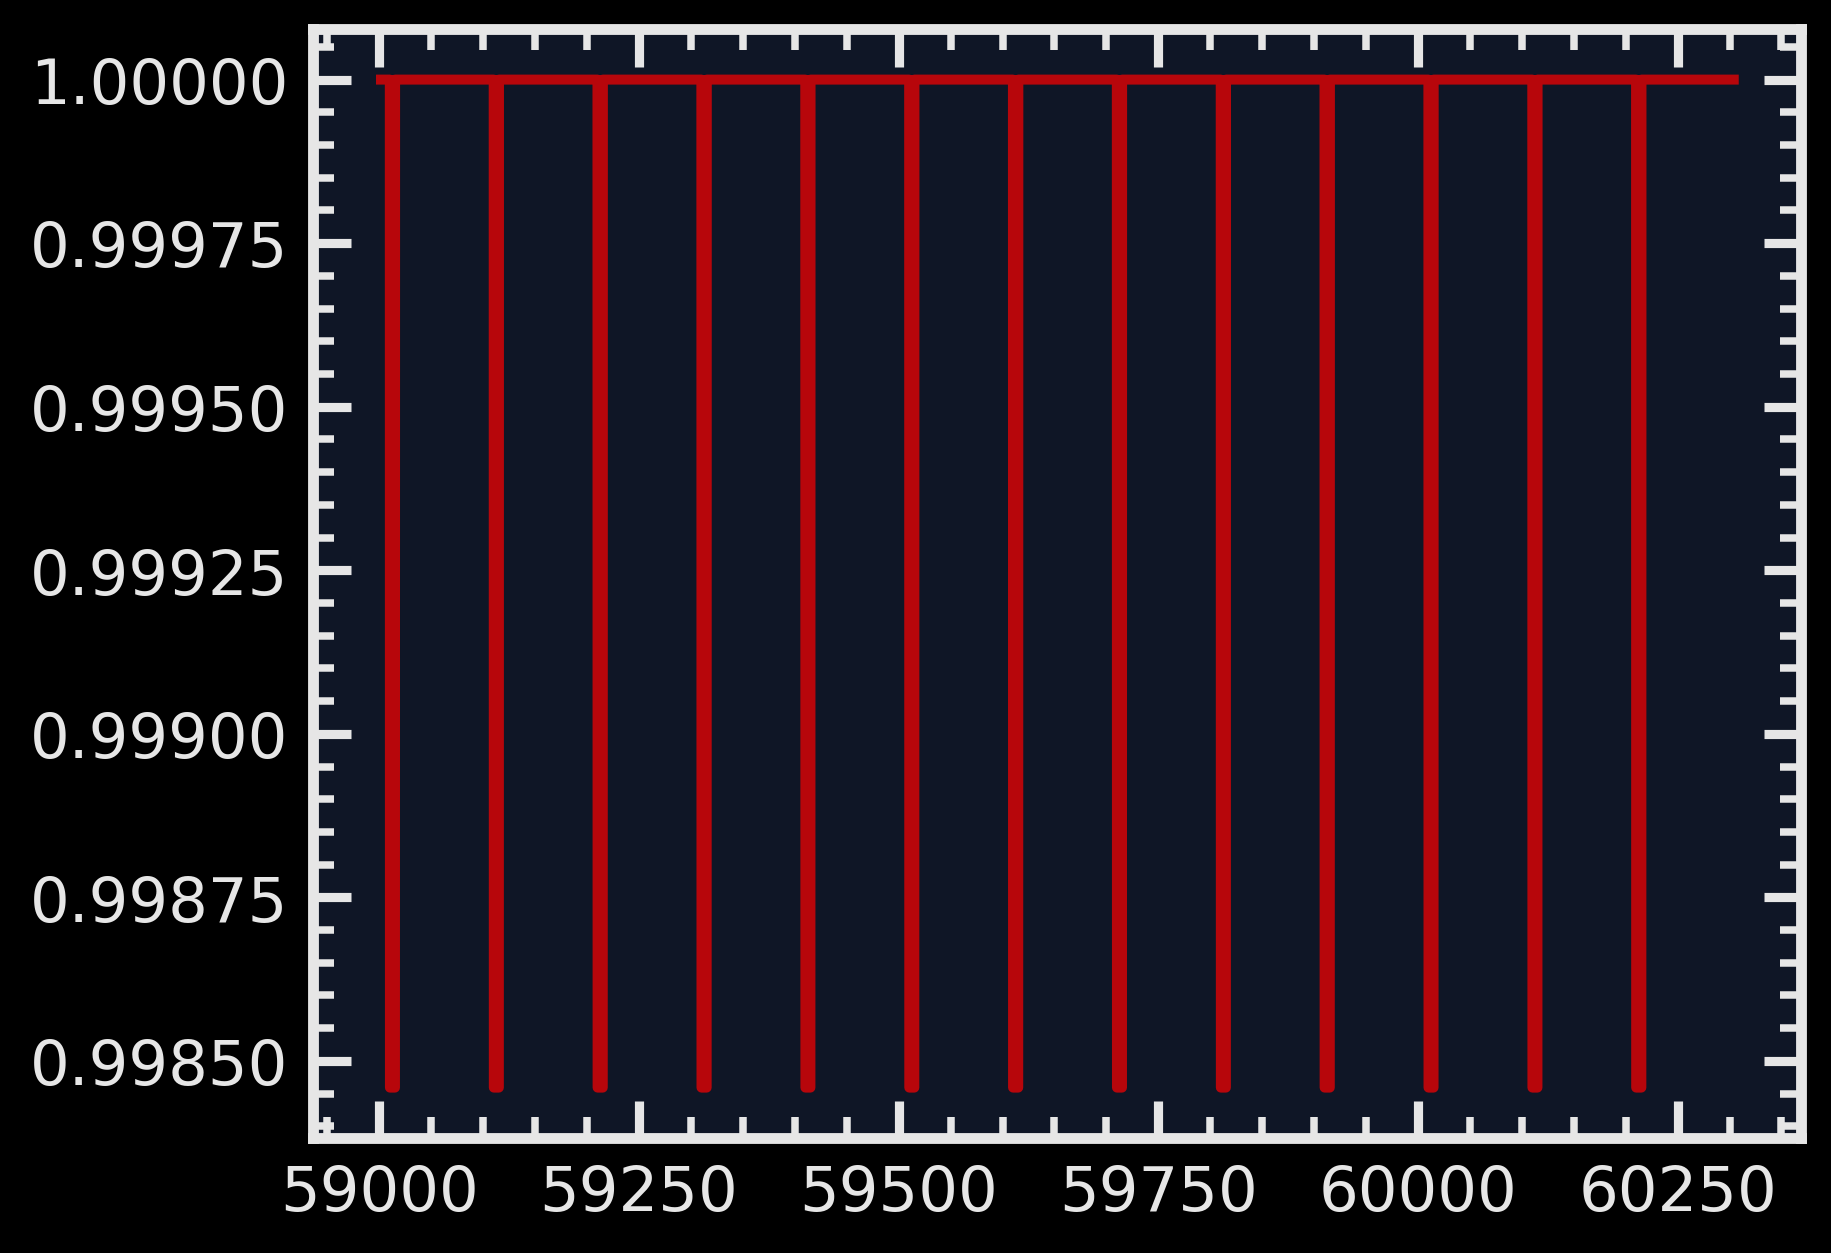

In [685]:
#plt.scatter(t, model)
#plt.plot(x_cont, model_cont, color='orange', alpha=0.7)
plt.plot(x_cont, model_repeat, color='red', alpha=0.7)


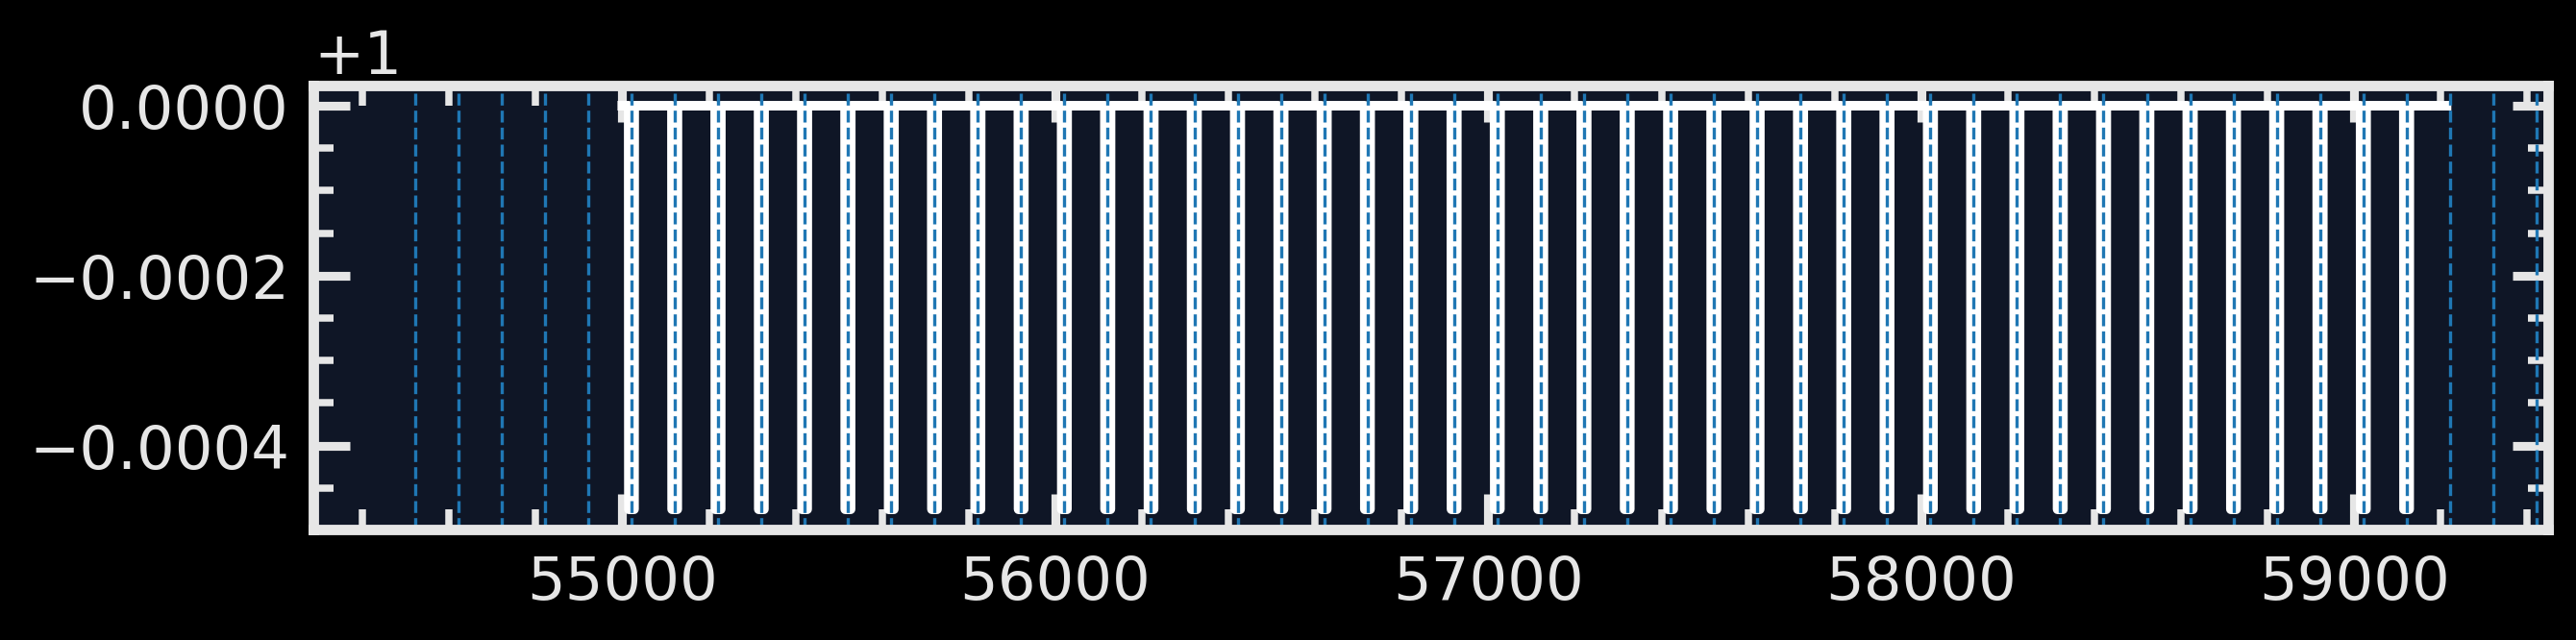

In [616]:
xli = np.linspace(55_000, 59_213.2, 10_000)
yli = repeat_square(xli, [55_521, 1, -1, 12.3], 100)

plt.figure(figsize=(10, 2))
plt.plot(xli, yli, color='w')


for i in range(-10,  40):
    plt.axvline(55_521 + i*100, ls='--', lw=0.8)

#plt.axvline(55_521)
#plt.axvline(55_521+100)
#plt.axvline(55_521+100+100)
#plt.axvline(55_521+100+100+100)

#plt.axvline(55_521+100+100+100+100)


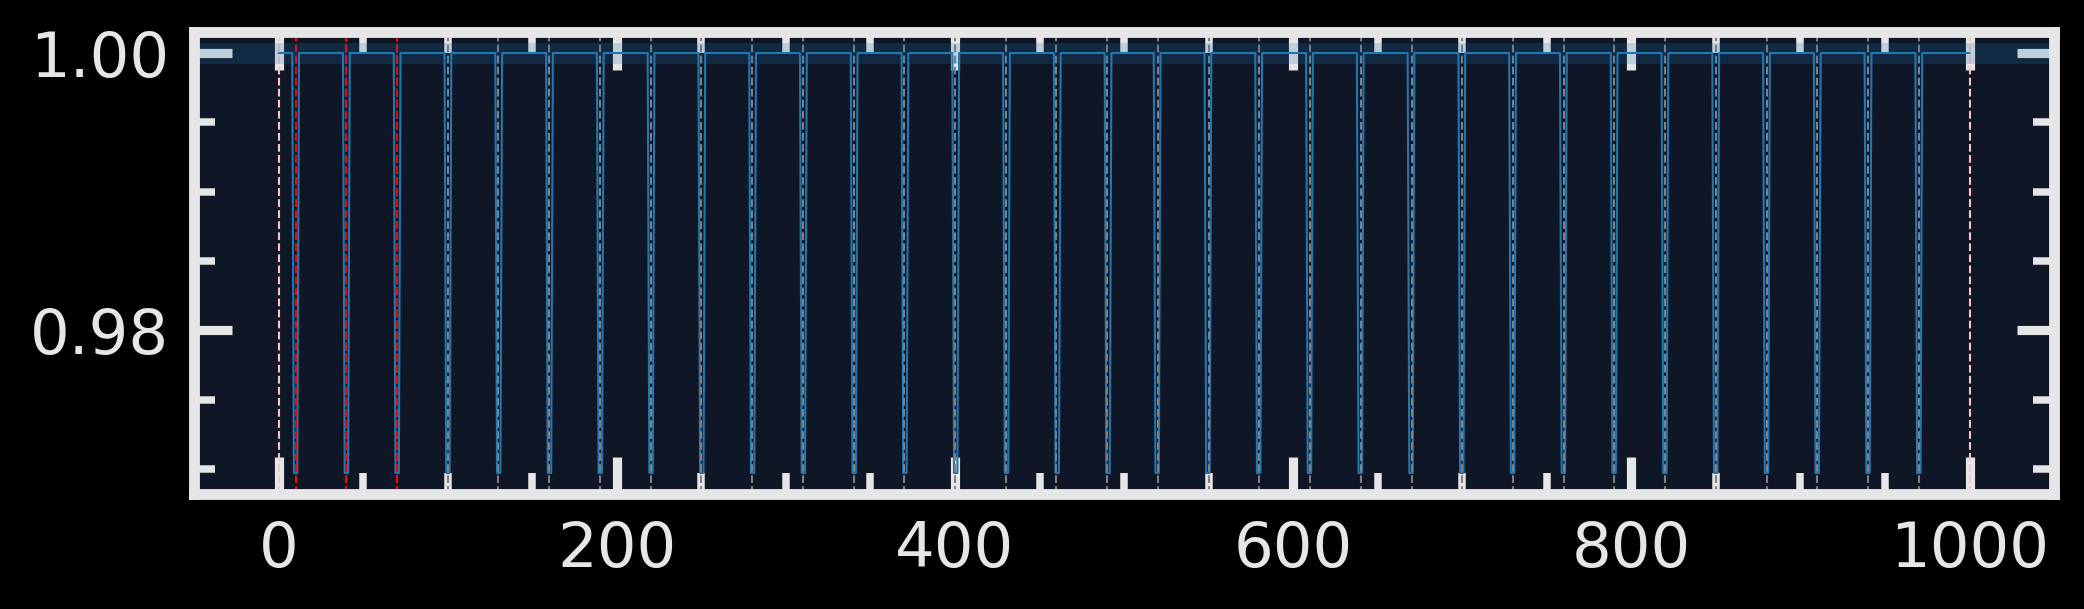

In [491]:
xli = np.linspace(0, 1000, 1000)
p_int = 30
t_start = 10

t0_all = []
yli = square_function(xli, t0=t_start, A=-1, C=1, width=3)

for i in range(1, int(1_000/30)):
    yli += square_function(xli, t0=t_start+i*p_int, A=-1, C=1, width=3)
    t0_all.append(t_start+i*p_int)

yli /= (int(1_000/30))

# plotter
plt.figure(figsize=(8,2))
plt.plot(xli, yli, lw=0.5)

for t00 in t0_all:
    plt.axvline(t00, color='gray', linestyle='--', lw=0.5)


plt.axvline(10, color='r', linestyle='--', lw=0.5)
plt.axvline(10+30, color='r', linestyle='--', lw=0.5)
plt.axvline(10 + 30 + 30 , color='r', linestyle='--', lw=0.5)

plt.axvline(np.min(xli), color='pink', linestyle='--', lw=0.5)
plt.axvline(np.max(xli), color='pink', linestyle='--', lw=0.5)
plt.axhline(1, lw=5, alpha=0.2)

In [490]:
t0_all = np.array(t0_all)

In [499]:
print (t0_all[0:3])

[40, 70, 100]


In [492]:
# phi = ((t - t0) / P + 0.5) % 1.0 - 0.5

33

In [415]:
xx = np.linspace(min(tobs), max(tobs), 10000)
yy = periodic_square(xx, t0=10, A=-1, C=1, width=10, period=5)

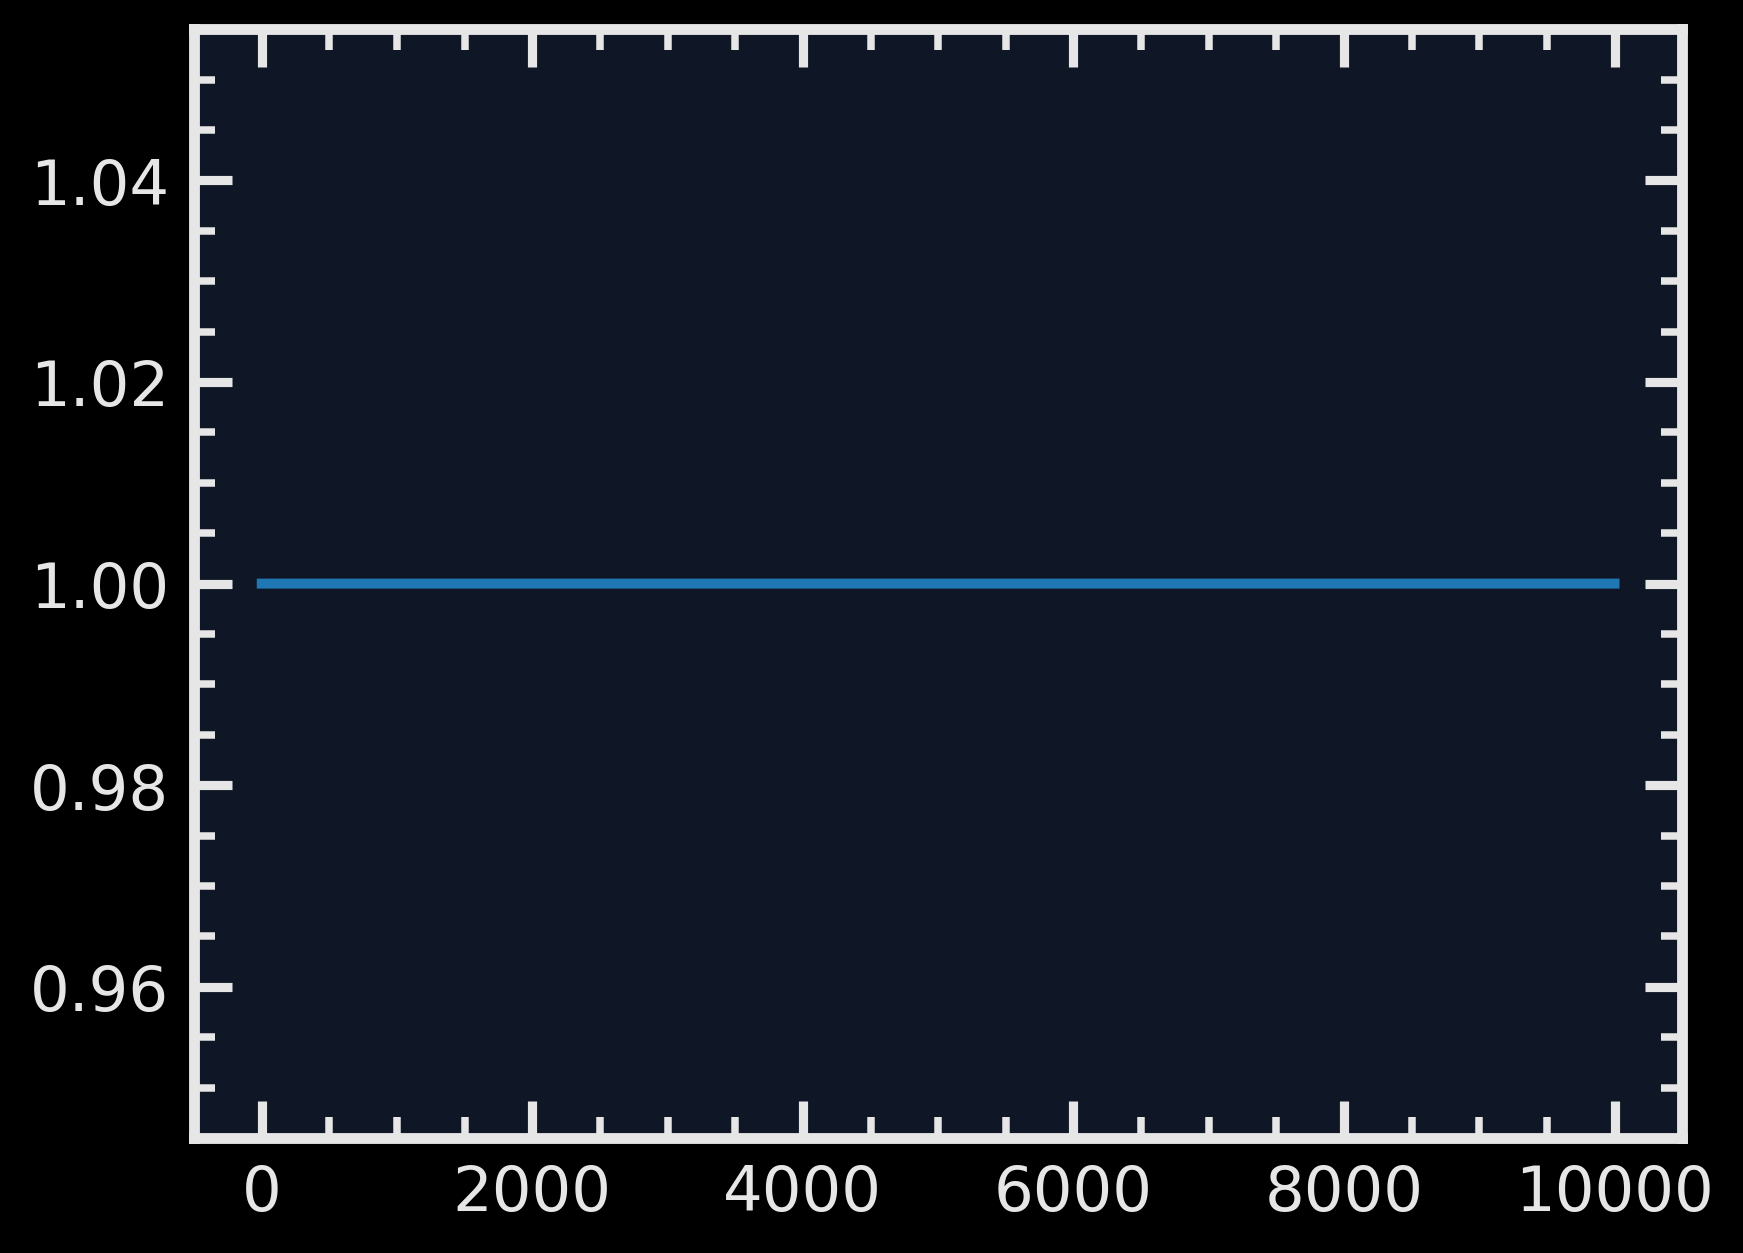

In [410]:
plt.plot(yy)

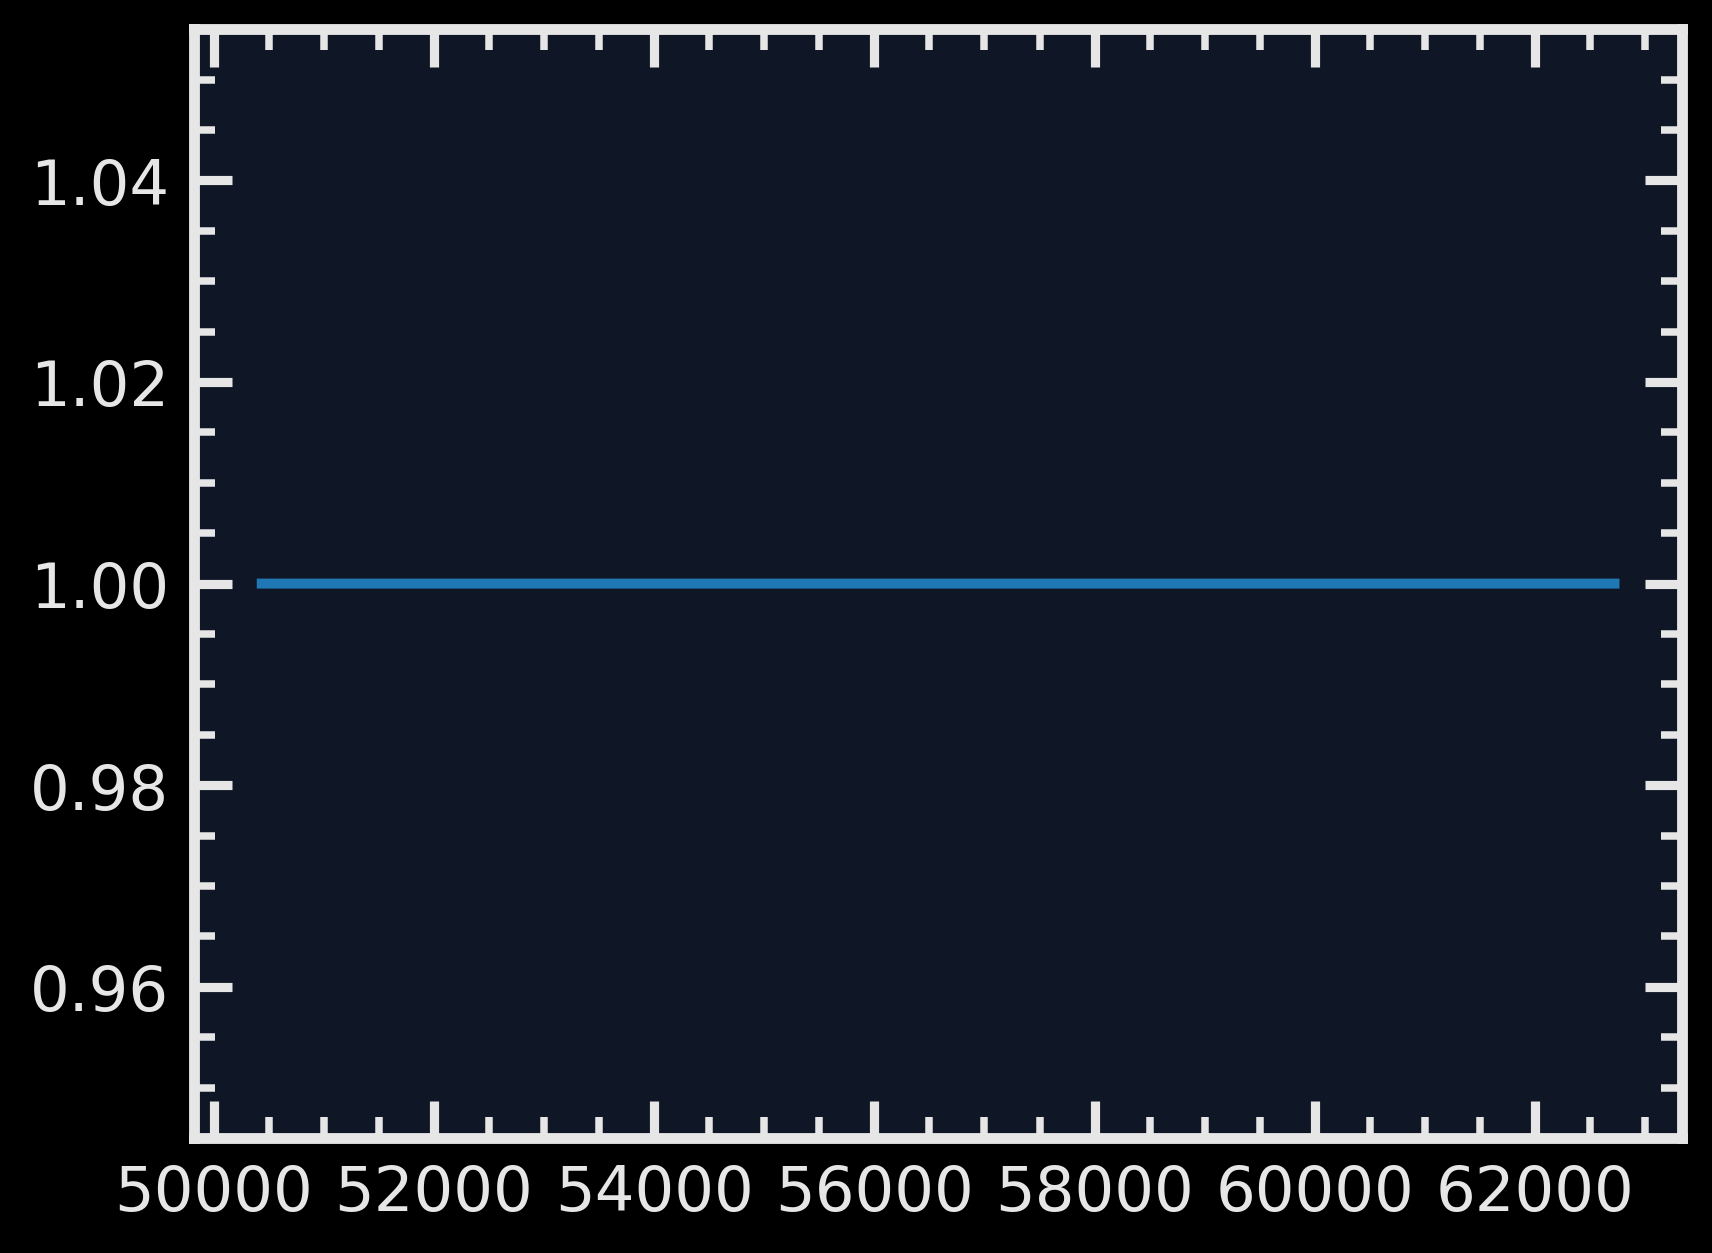

In [398]:
plt.plot(xx, Z)

In [391]:
xx = np.linspace(min(tobs), max(tobs), 10000)
yy = square_function(xx, t0=57100, A=-1, C=1, width=10)

# let's import scipy curve fit
from scipy.optimize import curve_fit

(57050.0, 57150.0)

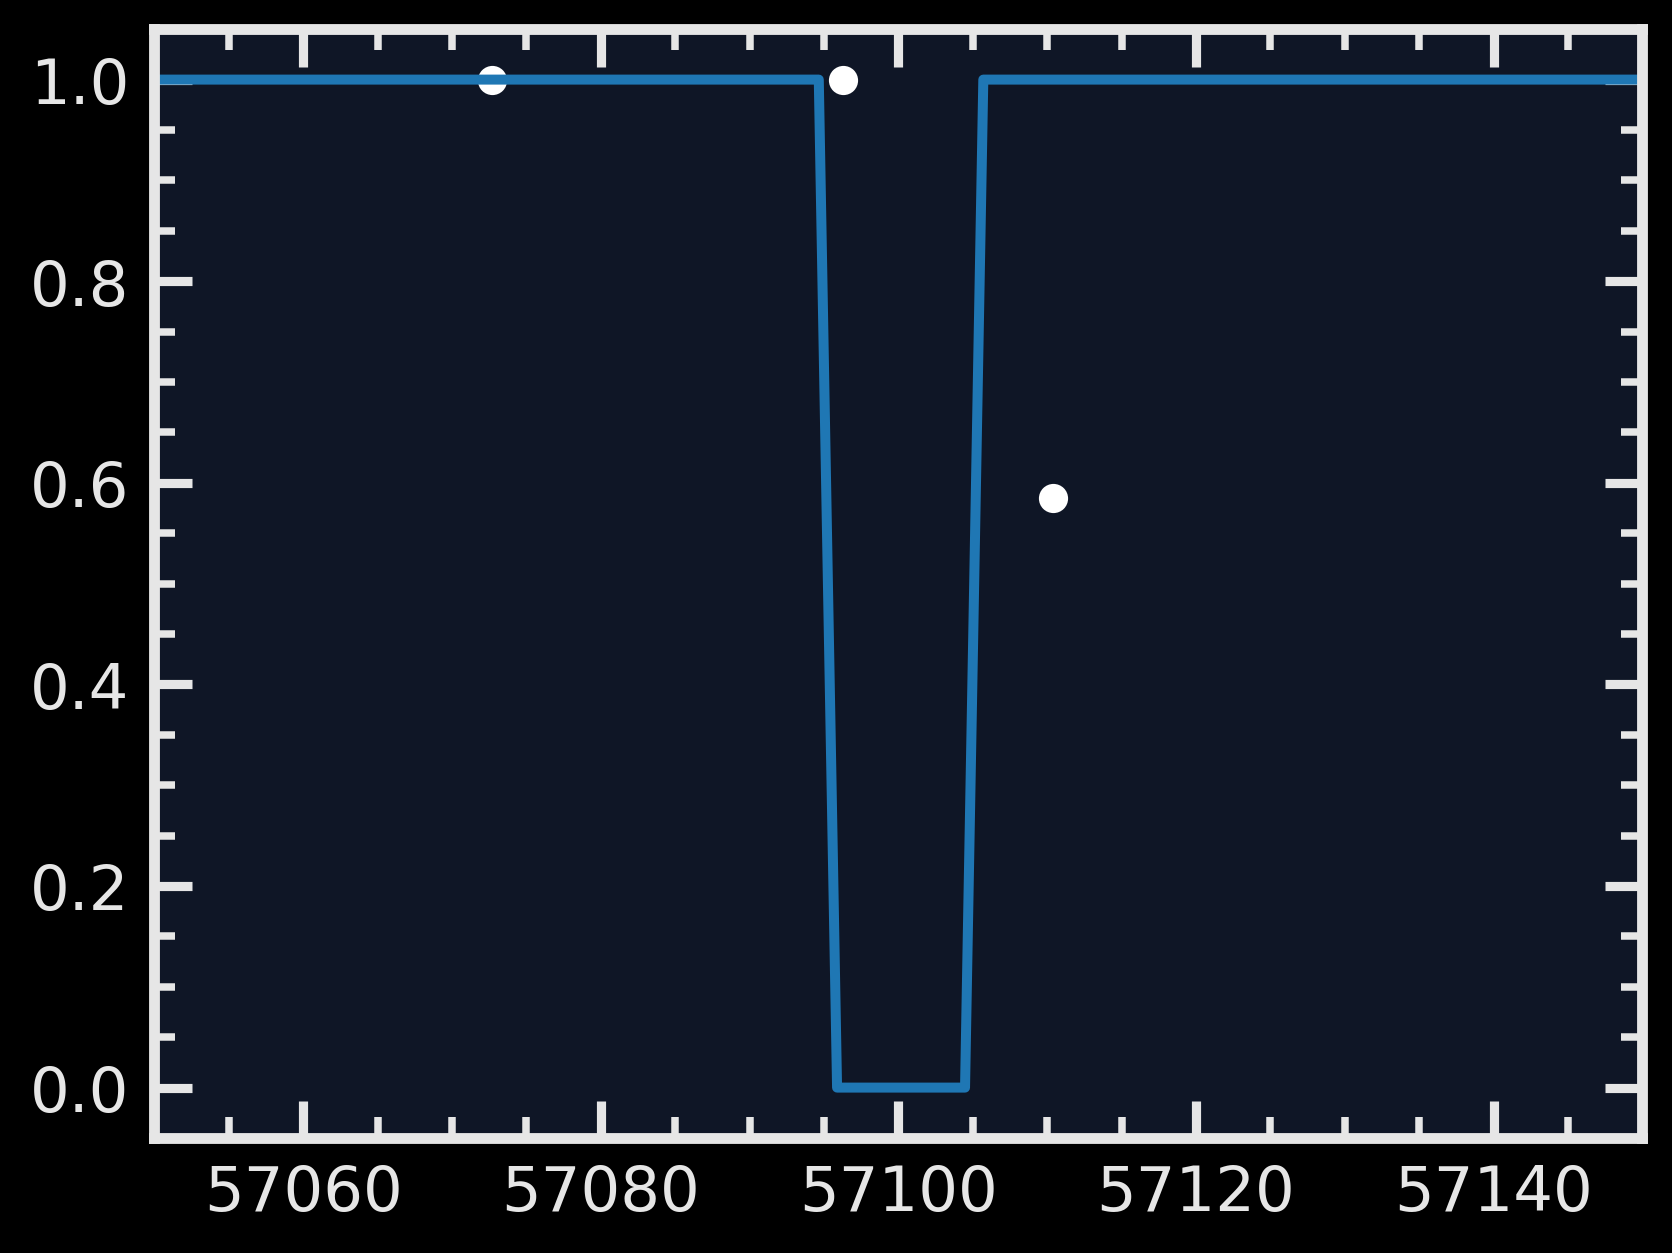

In [392]:
plt.plot(tobs, flux, 'o', label='Data', color='w')
plt.plot(xx, yy)

plt.xlim(57100-50, 57100+50)



/var/folders/xk/5g8l6b0d4r1dyg5f01jbjj800000gn/T/ipykernel_26527/3609186206.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  pf = curve_fit(square_function, x_fit, y_fit)


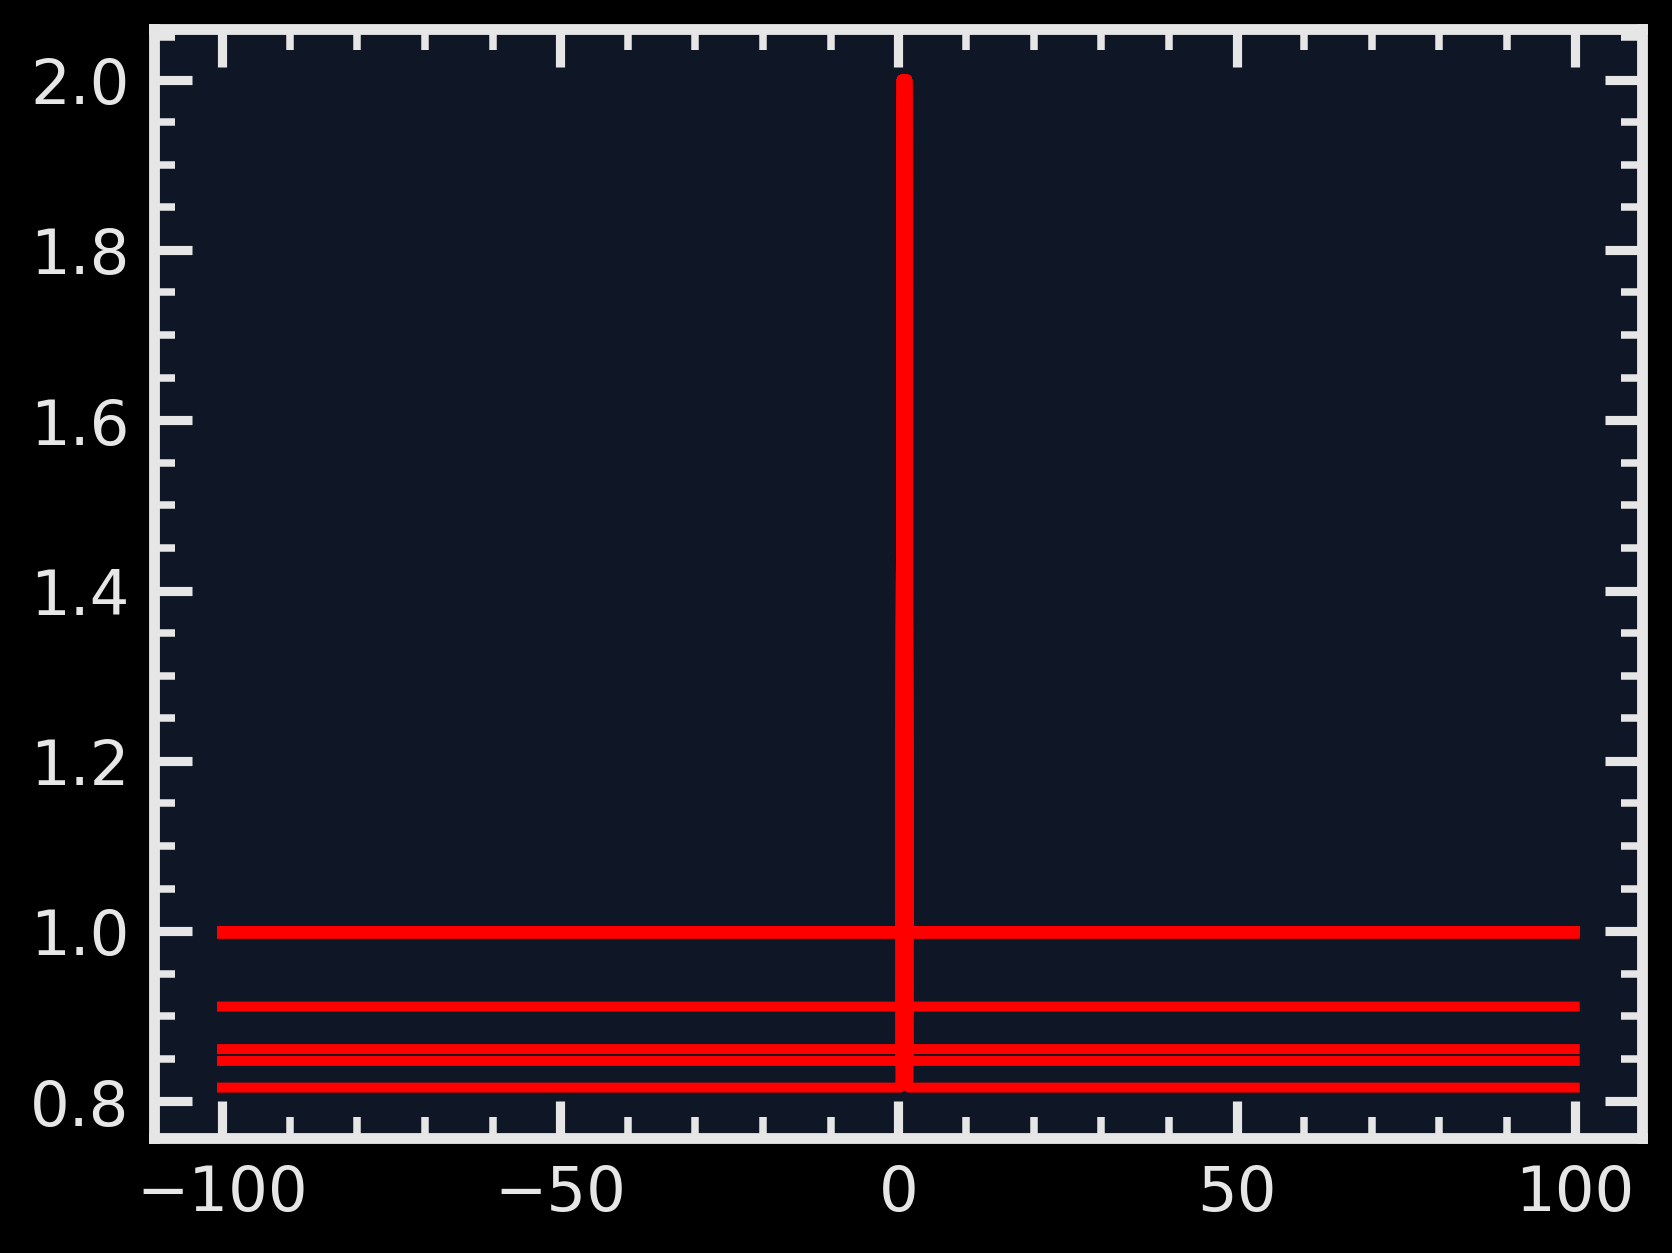

In [374]:
t_bins = np.arange(mjd_min, mjd_max, step=150)

for i in range(0, len(t_bins)-1):
    ww = (tobs >= t_bins[i]) & (tobs < t_bins[i+1])
    x_fit, y_fit = tobs[ww], flux[ww]
    
    if len(y_fit)<=3:
        continue

    pf = curve_fit(square_function, x_fit, y_fit)

    #plt.scatter(x_fit, y_fit)
    plt.plot(xx, square_function(xx, *pf[0]), color='r')

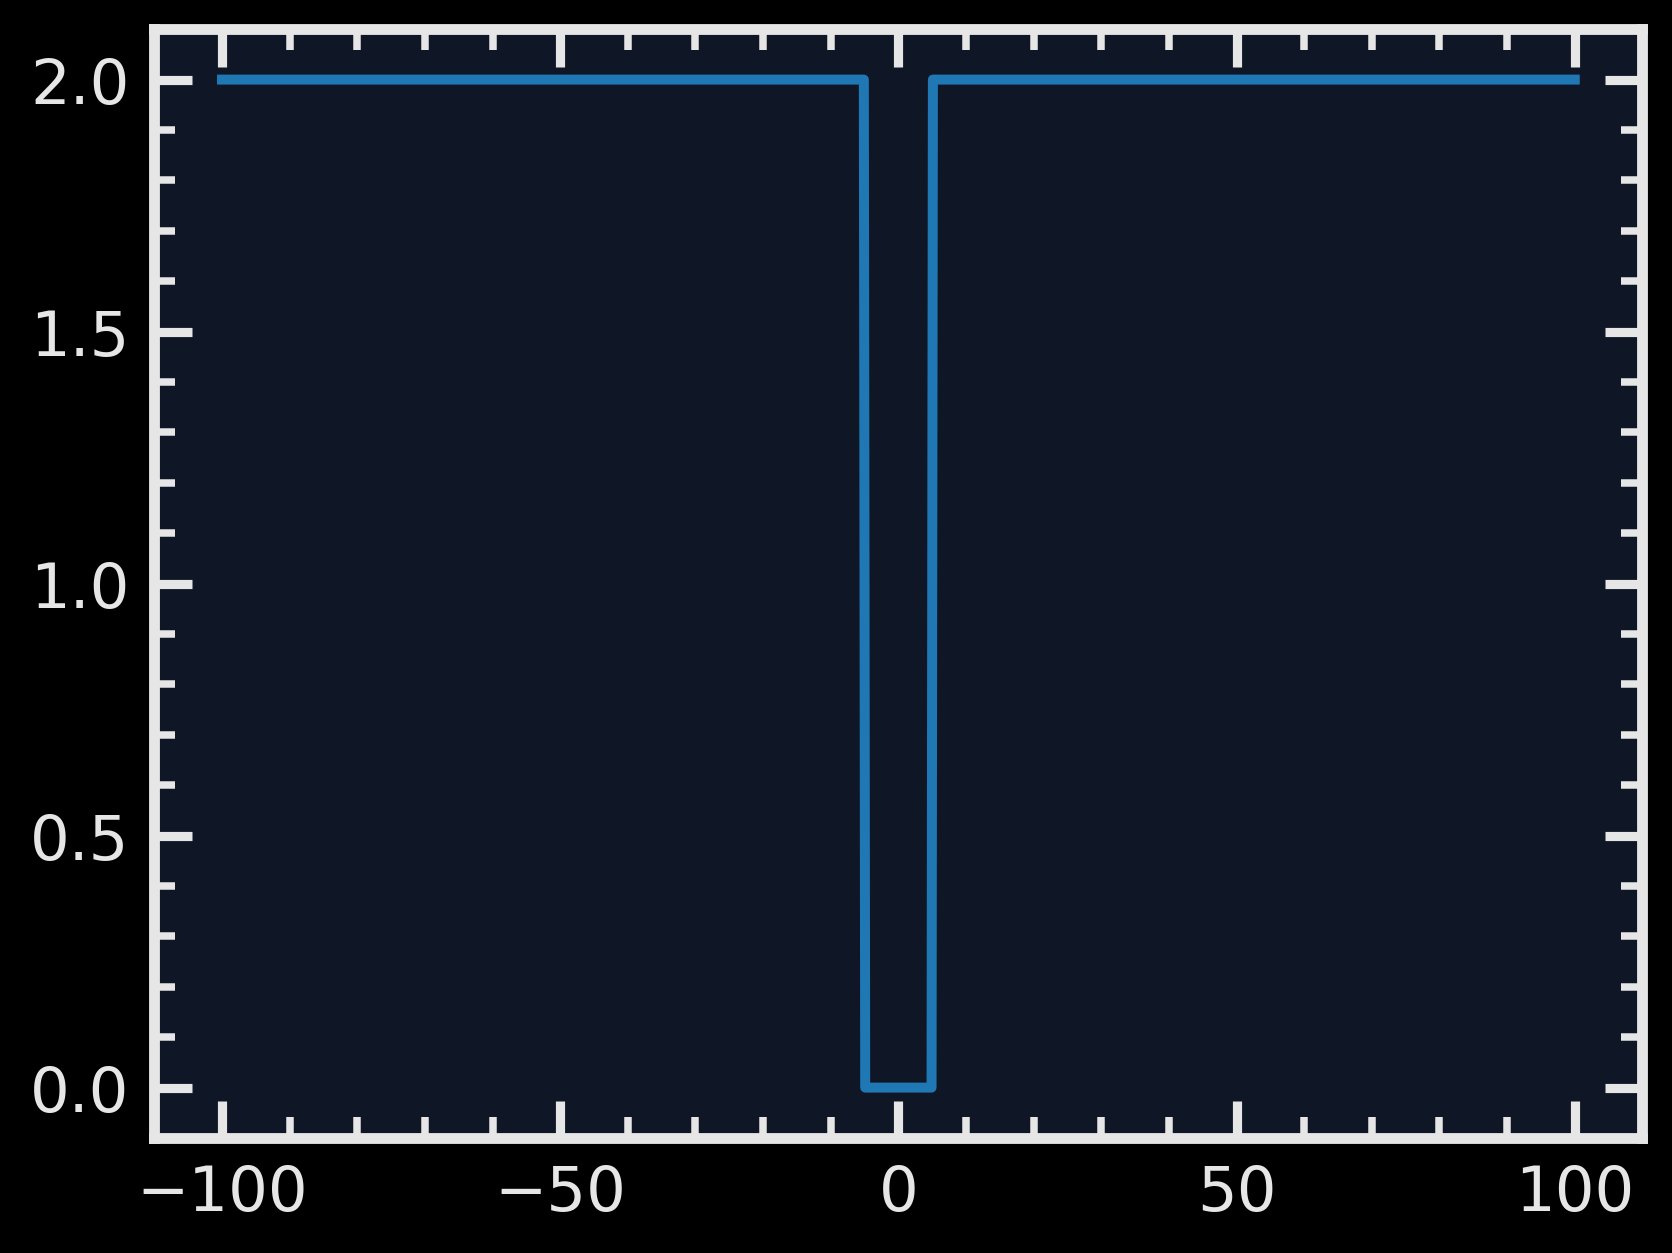

In [ ]:
plt.plot(xx, yy)
